# Likelihood-based models

This notebook will outline the likelihood-based approach to training on Bandit feedback.

Although before proceeding, we will study the output of the simulator in a little more detail.

In [1]:
import math
import numpy as np
import pandas as pd
from numpy.random.mtrand import RandomState
from recogym import Configuration
from recogym.agents import Agent
from sklearn.linear_model import LogisticRegression

from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym.agents import BanditCount, bandit_count_args, OrganicCount, organic_count_args
from recogym.agents import OrganicMFSquare, organic_mf_square_args, BanditMFSquare, bandit_mf_square_args
from recogym.agents import RandomAgent, random_args
from recogym.agents import FeatureProvider
from recogym import Configuration, DefaultContext, Observation
from recogym.envs.session import OrganicSessions
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale
from recogym.envs.utils_sale import *

import gym, recogym
from copy import deepcopy
from recogym import env_1_sale_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

num_users = 1000

env_1_sale_args['sigma_mu_organic'] = 0
env_1_sale_args['sigma_omega'] = 1
env_1_sale_args['random_seed'] = 42
env_1_sale_args['K'] = 5
env_1_sale_args['number_of_flips'] = 5
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

num_products = env_1_sale_args['num_products']

In [2]:
data = deepcopy(env).generate_logs(num_users)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:39<00:00, 25.15it/s]


## Likelihood agent

In [3]:
from recogym.envs.utils_sale import CountFeatureProvider, build_train_data, LikelihoodAgent

In [4]:
# You can now see data that will be provided to our agents based on logistic regressions.
config = Configuration(env_1_sale_args)
count_feature_provider = CountFeatureProvider(config=config)

user_states, actions, rewards, proba_actions = build_train_data(data, count_feature_provider)

In [5]:
%%time

count_product_views_feature_provider = CountFeatureProvider(config)

# likelihood agent
likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider)
likelihood_logreg.train(data)

Estimated sales rate :  [0.01922347 0.02294163 0.02182415 0.02303506 0.02318256 0.02188157
 0.0223478  0.02156912 0.02215109 0.0213255 ]
Wall time: 1min


## Baselines

In [6]:
from recogym.envs.utils_sale import SingleActionAgent

# Initialise baselines
random_agent = RandomAgent(Configuration(random_args))
sales = [data["r"][data['a']==a].sum() for a in range(num_products)]
_, views = np.unique(data[data['z'] == 'organic']['v'], return_counts=True)
greedy_bandit = SingleActionAgent(np.argmax(sales), Configuration(env_1_sale_args))
greedy_organic = SingleActionAgent(np.argmax(views), Configuration(env_1_sale_args))
count_organic = OrganicCount()
count_bandit = BanditCount()

In [7]:
result_baselines = verify_agents_sale(
    env,
    number_of_users=2000,
    agents={
        'random agent': random_agent,
        'greedy_organic':greedy_organic,
        'greedy_bandit':greedy_bandit,
        'count_organic':count_organic,
        'count_bandit':count_bandit
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [02:09<00:00, 15.50it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:44<00:00, 19.14it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:26<00:00, 23.23it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:28<00:00, 22.59it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:20<00:00, 24.76it/s]


## Likelihood, user organic count, bandit & organic MF

In [8]:
# organic user-specific counter agent
organic_user_counter_agent = OrganicUserEventCounterAgent(
    Configuration({
        **organic_user_count_args,
        **env_1_sale_args,
        'select_randomly': True,
    })
)

# Organic and bandit MF
organic_mf = OrganicMFSquare()
bandit_mf = BanditMFSquare()

In [9]:
result = verify_agents_sale(
    env,
    number_of_users=2000,
    agents={
        'Organic User Count': organic_user_counter_agent,
        'Likelihood LogReg': likelihood_logreg,
        'Organic MF' : organic_mf,
        'Bandit MF' : bandit_mf
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:51<00:00, 18.00it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [02:27<00:00, 13.53it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:34<00:00, 21.27it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [02:13<00:00, 15.00it/s]


## Contextual bandit : vanilla, log & POEM

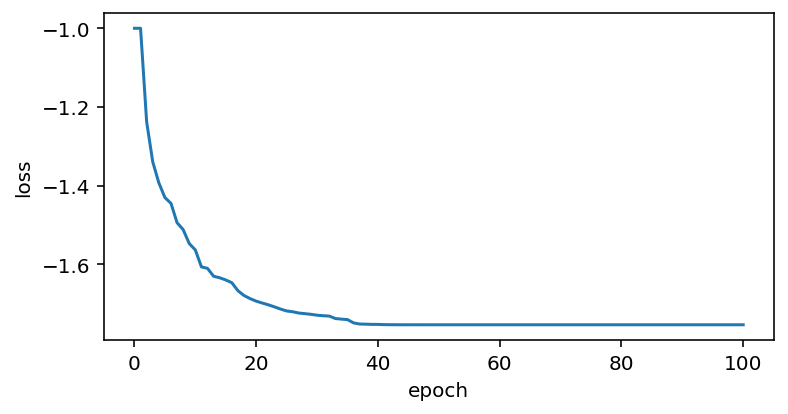

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:41<00:00, 19.63it/s]


In [10]:
from recogym.envs.utils_sale import ProductCountFeatureProvider, VanillaContextualBandit, MultinomialLogisticRegressionModel,build_rectangular_data
from recogym.envs.utils_sale import LogContextualBandit, PoemContextualBandit

rectangular_logs = build_rectangular_data(data, count_product_views_feature_provider)

vanilla_cb = VanillaContextualBandit({}, max_epoch=100)
vanilla_cb.train(rectangular_logs)
vanilla_cb.plot_loss_history()
result_AB_vanillaCB = verify_agents_sale(env, 2000, {'Contextual Bandit': vanilla_cb})


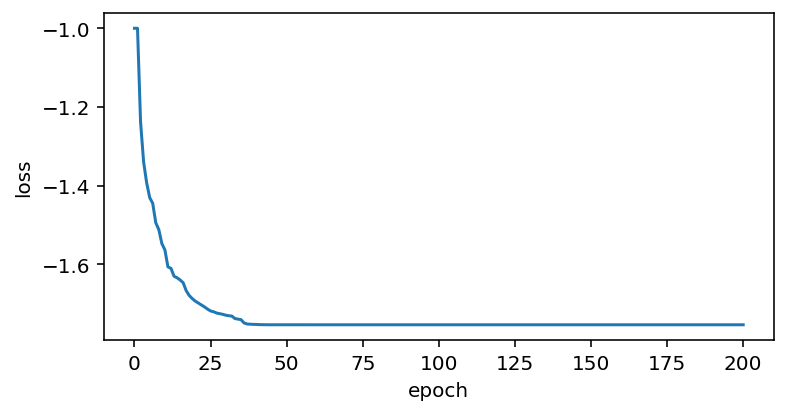

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:45<00:00, 19.04it/s]


In [11]:
log_cb = LogContextualBandit({}, max_epoch=200)
log_cb.train(rectangular_logs)
log_cb.plot_loss_history()
result_AB_LogCB = verify_agents_sale(env, 2000, {'Log Contextual Bandit': log_cb})

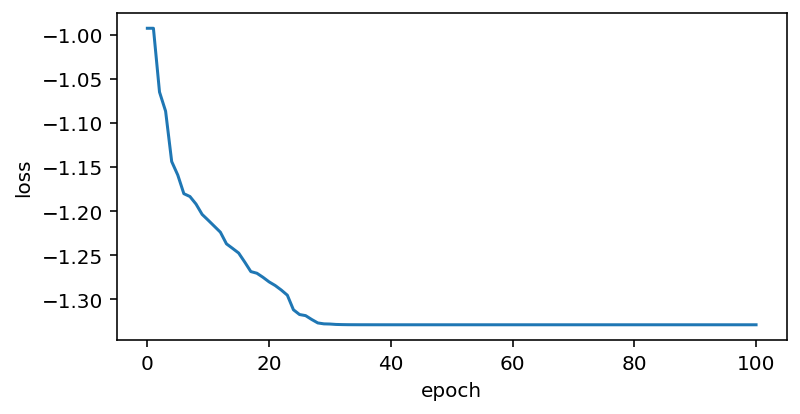

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:47<00:00, 18.61it/s]


In [46]:
poem = PoemContextualBandit({}, variance_penalization_factor=0.4, max_epoch=100)
poem.train(rectangular_logs)
poem.plot_loss_history()
result_AB_POEM = verify_agents_sale(env, 2000, {f'POEM': poem})

## Oracles

In [320]:
class ViewSaleOracleAgent(Agent, RecoEnv1Sale):
    """
    Sale Oracle

    Has access to user and product features and popularity
    """

    def __init__(self, env):
        super(ViewSaleOracleAgent, self).__init__(env)
        self.env = env

    def act(self, observation, reward, done):
        """Make a recommendation"""
        self.omega = self.env.omega
        self.delta = self.env.delta
        if "delta_for_views" in dir(self.env.config) is not None & self.env.config.delta_for_views == True :
            self.user_feature_view = self.delta
        else :
            self.user_feature_view = self.omega
        
        # Proba of viewing each product
        log_proba_view = np.array([self.user_feature_view[:,0]@self.Gamma[int(a),:] + self.mu_organic[int(a)] for a in range(self.env.config.num_products)])
        proba_view = np.exp(log_proba_view - max(log_proba_view))
        proba_view = proba_view / proba_view.sum()
        proba_view = proba_view[:,0]
        
        # Difference in sale mean for each product if the product is recommended
        proba_with_click = np.array([sig(((1-self.kappa)*self.delta[:,0] + self.kappa*self.Lambda[int(a),:])@self.Lambda[int(a),:]) for a in range(self.env.config.num_products)])
        proba_no_click = np.array([sig(self.delta[:,0]@self.Lambda[int(a),:]) for a in range(self.env.config.num_products)])
        
        proba_difference = proba_with_click - proba_no_click
        
        # Take argmax
        action = np.argmax(proba_view * proba_difference)
        self.list_actions.append(action)
        
        if self.env.config.with_ps_all:
            ps_all = np.zeros(self.config.num_products)
            ps_all[action] = 1.0
        else:
            ps_all = ()

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': self.env.config.psale_scale*sig(self.Lambda[int(action),:] @ (self.delta))[0],
                'ps-a': ps_all,
            },
        }

    def history(self):
        return self.list_actions

    def reset(self):
        self.list_actions = []
        self.kappa = self.env.config.kappa
        self.omega = self.env.omega
        self.delta = self.env.delta
        if "delta_for_views" in dir(self.env.config) is not None & self.env.config.delta_for_views == True :
            self.user_feature_view = self.delta
        else :
            self.user_feature_view = self.omega
        self.Lambda = self.env.Lambda
        self.Gamma = self.env.Gamma
        self.mu_organic = self.env.mu_organic
        self.list_actions = []



In [339]:
class ClickViewSaleOracleAgent(Agent, RecoEnv1Sale):
    """
    Sale Oracle

    Has access to user and product features and popularity
    """

    def __init__(self, env):
        super(ClickViewSaleOracleAgent, self).__init__(env)
        self.env = env

    def act(self, observation, reward, done):
        """Make a recommendation"""
        self.omega = self.env.omega
        self.delta = self.env.delta
        
        if "delta_for_views" in dir(self.env.config) is not None & self.env.config.delta_for_views == True :
            self.user_feature_view = self.delta
        else :
            self.user_feature_view = self.omega
        
        if ("delta_for_clicks" in dir(self.env.config)) & (self.env.config.delta_for_clicks == 1):
            self.user_feature_click = self.delta
        else :
            self.user_feature_click = self.omega
        

        # Proba of clicking for each product
        proba_click = np.array([ff(self.user_feature_click[:,0]@self.beta[int(a),:] + self.mu_bandit[int(a)]) for a in range(self.env.config.num_products)])
        
        # Proba of viewing each product
        log_proba_view = np.array([self.user_feature_view[:,0]@self.Gamma[int(a),:] + self.mu_organic[int(a)] for a in range(self.env.config.num_products)])
        proba_view = np.exp(log_proba_view - max(log_proba_view))
        proba_view = proba_view / proba_view.sum()
        proba_view = proba_view[:,0]
        
        # Difference in sale mean for each product if the product is recommended
        proba_with_click = np.array([sig(((1-self.kappa)*self.delta[:,0] + self.kappa*self.Lambda[int(a),:])@self.Lambda[int(a),:]) for a in range(self.env.config.num_products)])
        proba_no_click = np.array([sig(self.delta[:,0]@self.Lambda[int(a),:]) for a in range(self.env.config.num_products)])
        proba_difference = proba_with_click - proba_no_click
        
        # Take argmax
        action = np.argmax(proba_view * proba_difference)
        self.list_actions.append(action)
        
        if self.env.config.with_ps_all:
            ps_all = np.zeros(self.config.num_products)
            ps_all[action] = 1.0
        else:
            ps_all = ()

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': self.env.config.psale_scale*sig(self.Lambda[int(action),:] @ (self.delta))[0],
                'ps-a': ps_all,
            },
        }

    def history(self):
        return self.list_actions

    def reset(self):
        self.list_actions = []
        self.kappa = self.env.config.kappa
        self.omega = self.env.omega
        self.delta = self.env.delta
        
        if "delta_for_views" in dir(self.env.config) is not None & self.env.config.delta_for_views == True :
            self.user_feature_view = self.delta
        else :
            self.user_feature_view = self.omega
        
        if ("delta_for_clicks" in dir(self.env.config)) & (self.env.config.delta_for_clicks ==1) :
            self.user_feature_click = self.delta
        else :
            self.user_feature_click = self.omega
        self.beta = self.env.beta
        self.Lambda = self.env.Lambda
        self.Gamma = self.env.Gamma
        self.mu_organic = self.env.mu_organic
        self.mu_bandit = self.env.mu_bandit
        self.list_actions = []



In [ ]:
# from recogym.agents.sale_oracle import ClickViewSaleOracleAgent

cvs_oracle = ClickViewSaleOracleAgent(env=env)
cvs_oracle.reset()
result_cvs_oracle = verify_agents_sale(env, 2000, {'Click View Sale oracle': cvs_oracle}, agent_reset = True)

Organic Users: 0it [00:00, ?it/s]
Users:   5%|███▋                                                                    | 104/2000 [00:23<11:19,  2.79it/s]

In [322]:
# from recogym.agents.sale_oracle import ViewSaleOracleAgent
vs_oracle = ViewSaleOracleAgent(env=env)
vs_oracle.reset()
result_vs_oracle = verify_agents_sale(env, 2000, {'View Sale oracle': vs_oracle}, agent_reset = True)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [03:02<00:00, 10.98it/s]


In [282]:
# from recogym.agents.sale_oracle import SaleOracleAgent
sale_oracle = SaleOracleAgent(env = env)
sale_oracle.reset()
result_AB_sale_oracle = verify_agents_sale(deepcopy(env), 2000, {'Sale oracle': sale_oracle})

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.10it/s]


## Compare results

In [ ]:
result_concat = (pd.concat([result_baselines[0],result[0],
                            result_AB_vanillaCB[0],result_AB_LogCB[0],
                            result_AB_POEM[0],
#                             result_AB_test[0],
                            result_AB_sale_oracle[0],
                            result_vs_oracle[0],
                            result_cvs_oracle[0]
                           ]),
                pd.concat([result_baselines[1],result[1],
                           result_AB_vanillaCB[1],result_AB_LogCB[1],
                           result_AB_POEM[1],
#                            result_AB_test[1],
                           result_AB_sale_oracle[1],
                           result_vs_oracle[1],
                           result_cvs_oracle[1]
                          ]))

In [ ]:
result_concat[0]

In [ ]:
fig = plot_verify_agents_sale(*result_concat)
plt.show()